Loaded 50 data points successfully.

Model fitting complete:
Model 1 SSE = 0.824238
Model 2 SSE = 0.990032
Model 3 SSE = 1.232896

Variance (σ²) estimates:
Model 1: 1.831641e-02
Model 2: 2.152244e-02
Model 3: 2.739769e-02
Model 1: Shapiro–Wilk W = 0.9742, p = 0.3409
Model 2: Shapiro–Wilk W = 0.9658, p = 0.1551
Model 3: Shapiro–Wilk W = 0.9794, p = 0.5272


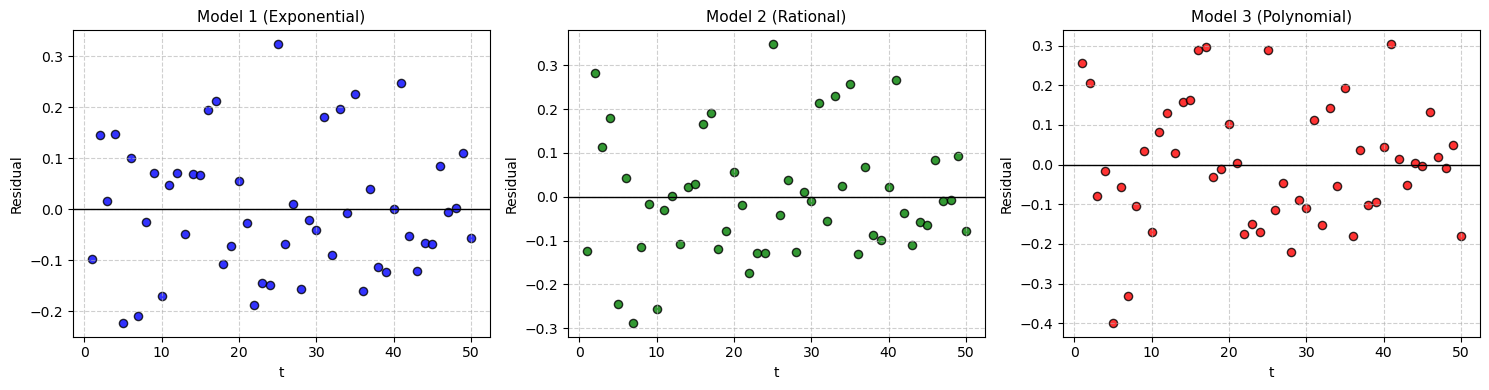

Saved: nlr_outputs/residuals_side_by_side.png


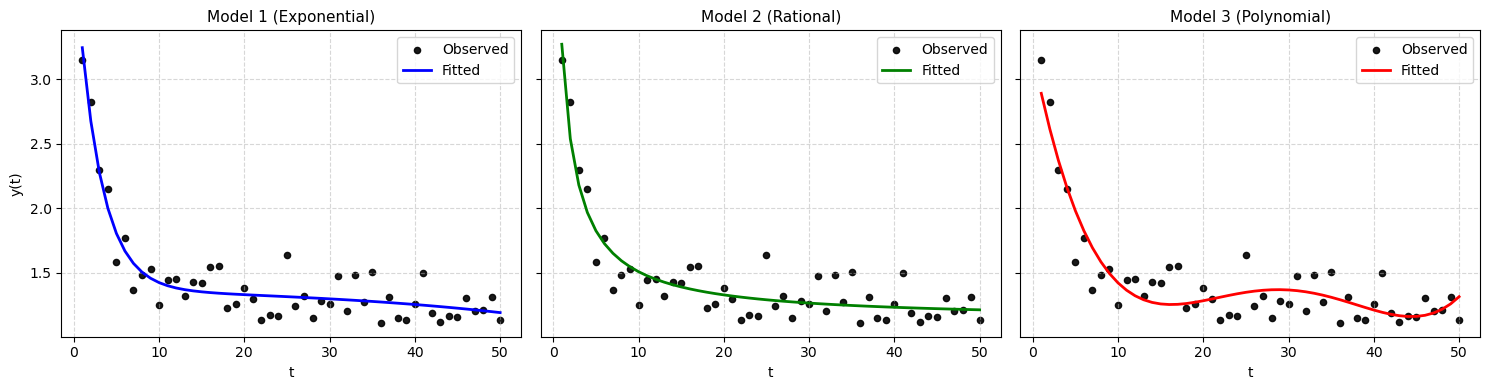

Saved: nlr_outputs/observed_vs_fitted_side_by_side.png


In [13]:
import os
import numpy as np
import pdfplumber
import matplotlib.pyplot as plt
from scipy.stats import t as student_t, shapiro

# Create output folder if it doesn't exist
os.makedirs("nlr_outputs", exist_ok=True)

# -----------------------------
# Load dataset from the given PDF
# -----------------------------
pdf_path = "set-69 simple.pdf"
t_vals, y_vals = [], []
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        for line in text.split("\n"):
            parts = line.strip().split()
            if len(parts) == 2 and parts[0].isdigit():
                t_vals.append(float(parts[0]))
                y_vals.append(float(parts[1]))
t = np.array(t_vals)
y = np.array(y_vals)
n = len(y)
print(f"Loaded {n} data points successfully.")

# Scale t for exponential model
t_scaled = (t - t.min()) / (t.max() - t.min())

# -----------------------------
# Model definitions
# -----------------------------
def model1(t, a0, a1, b1, a2, b2):
    return a0 + a1 * np.exp(b1 * t) + a2 * np.exp(b2 * t)

def model2(t, a0, a1, b0, b1):
    return (a0 + a1 * t) / (b0 + b1 * t)

def model3(t, b0, b1, b2, b3, b4):
    return b0 + b1 * t + b2 * t**2 + b3 * t**3 + b4 * t**4

# Jacobian matrices
def jacobian_model1(t, theta):
    a0, a1, b1, a2, b2 = theta
    e1 = np.exp(b1 * t)
    e2 = np.exp(b2 * t)
    J = np.zeros((len(t), 5))
    J[:, 0] = 1
    J[:, 1] = e1
    J[:, 2] = a1 * t * e1
    J[:, 3] = e2
    J[:, 4] = a2 * t * e2
    return J

def jacobian_model2(t, theta):
    a0, a1, b0, b1 = theta
    denom = (b0 + b1 * t)
    J = np.zeros((len(t), 4))
    J[:, 0] = 1 / denom
    J[:, 1] = t / denom
    J[:, 2] = -(a0 + a1 * t) / (denom**2)
    J[:, 3] = -(a0 + a1 * t) * t / (denom**2)
    return J

# -----------------------------
# Damped Gauss–Newton Algorithm
# -----------------------------
def gauss_newton_damped(model_func, jac_func, t_data, y_data, theta0,
                        lam=1e-3, tol=1e-8, max_iter=200):
    theta = np.array(theta0, float)
    for _ in range(max_iter):
        f = model_func(t_data, *theta)
        r = y_data - f
        J = jac_func(t_data, theta)
        A = J.T @ J + lam * np.eye(len(theta))
        g = J.T @ r
        delta = np.linalg.solve(A, g)
        theta_new = theta + delta
        SSE_old = np.sum(r**2)
        SSE_new = np.sum((y_data - model_func(t_data, *theta_new))**2)
        if SSE_new < SSE_old:
            lam *= 0.7
            theta = theta_new
        else:
            lam *= 2.0
        if np.linalg.norm(delta) < tol:
            break
    res = y_data - model_func(t_data, *theta)
    SSE = np.sum(res**2)
    return theta, SSE, J, res

# -----------------------------
# Fit all models
# -----------------------------
mean_y = np.mean(y)
theta1, SSE1, J1, res1 = gauss_newton_damped(model1, jacobian_model1, t_scaled, y, [mean_y, 0.8, -2.0, 0.5, -0.5])
theta2, SSE2, J2, res2 = gauss_newton_damped(model2, jacobian_model2, t, y, [mean_y, -0.05, 1.0, 0.01])
theta3 = np.polyfit(t, y, 4)[::-1]
X = np.column_stack([np.ones(n), t, t**2, t**3, t**4])
res3 = y - X @ theta3
SSE3 = np.sum(res3**2)

print("\nModel fitting complete:")
print(f"Model 1 SSE = {SSE1:.6f}")
print(f"Model 2 SSE = {SSE2:.6f}")
print(f"Model 3 SSE = {SSE3:.6f}")

# -----------------------------
# Variance estimates and confidence intervals
# -----------------------------
def cov_confidence(J, theta_hat, sigma2):
    p = len(theta_hat)
    cov = sigma2 * np.linalg.pinv(J.T @ J)
    se = np.sqrt(np.diag(cov))
    tcrit = student_t.ppf(0.975, df=len(J) - p)
    lower = theta_hat - tcrit * se
    upper = theta_hat + tcrit * se
    return cov, se, lower, upper

def linear_cov(X, theta, sigma2):
    cov = sigma2 * np.linalg.pinv(X.T @ X)
    se = np.sqrt(np.diag(cov))
    tcrit = student_t.ppf(0.975, df=len(X) - len(theta))
    lower = theta - tcrit * se
    upper = theta + tcrit * se
    return cov, se, lower, upper

p1, p2, p3 = len(theta1), len(theta2), len(theta3)
sigma2_1 = SSE1 / (n - p1)
sigma2_2 = SSE2 / (n - p2)
sigma2_3 = SSE3 / (n - p3)

cov1, se1, lower1, upper1 = cov_confidence(J1, theta1, sigma2_1)
cov2, se2, lower2, upper2 = cov_confidence(J2, theta2, sigma2_2)
cov3, se3, lower3, upper3 = linear_cov(X, theta3, sigma2_3)

print("\nVariance (σ²) estimates:")
print(f"Model 1: {sigma2_1:.6e}")
print(f"Model 2: {sigma2_2:.6e}")
print(f"Model 3: {sigma2_3:.6e}")

# -----------------------------
# Normality check (Shapiro–Wilk)
# -----------------------------
for i, r in enumerate([res1, res2, res3], start=1):
    stat, pval = shapiro(r)
    print(f"Model {i}: Shapiro–Wilk W = {stat:.4f}, p = {pval:.4f}")

# -----------------------------
# Residual plots (side-by-side)
# -----------------------------
models = ["Model 1 (Exponential)", "Model 2 (Rational)", "Model 3 (Polynomial)"]
residuals = [res1, res2, res3]
colors = ["blue", "green", "red"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, res, title, color in zip(axes, residuals, models, colors):
    ax.scatter(t, res, color=color, s=35, edgecolor="black", alpha=0.8)
    ax.axhline(0, color="black", lw=1)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("t")
    ax.set_ylabel("Residual")
    ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("nlr_outputs/residuals_side_by_side.png", dpi=300)
plt.show()
print("Saved: nlr_outputs/residuals_side_by_side.png")

# -----------------------------
# Observed data vs fitted curves (side-by-side)
# -----------------------------
y1_hat = model1(t_scaled, *theta1)
y2_hat = model2(t, *theta2)
y3_hat = model3(t, *theta3)
fits = [y1_hat, y2_hat, y3_hat]

# Sort data for smooth fitted curves
sort_idx = np.argsort(t)
t_sorted = t[sort_idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, fit, title, color in zip(axes, fits, models, colors):
    fit_sorted = fit[sort_idx]
    ax.scatter(t, y, color="black", s=20, label="Observed", alpha=0.9)
    ax.plot(t_sorted, fit_sorted, color=color, lw=2, label="Fitted")
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("t")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()
axes[0].set_ylabel("y(t)")
plt.tight_layout()
plt.savefig("nlr_outputs/observed_vs_fitted_side_by_side.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: nlr_outputs/observed_vs_fitted_side_by_side.png")
